In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
# Importing necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

import os

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [7]:
!pip install patool

In [8]:
import patoolib
patoolib.extract_archive("/content/drive/My Drive/Colab Notebooks/R9/images_racoon.rar", outdir="/content/drive/My Drive/Colab Notebooks/R9/")

patool: Extracting /content/drive/My Drive/Colab Notebooks/R9/images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Colab Notebooks/R9/images_racoon.rar"
patool:     with cwd='/content/drive/My Drive/Colab Notebooks/R9/'
patool: ... /content/drive/My Drive/Colab Notebooks/R9/images_racoon.rar extracted to `/content/drive/My Drive/Colab Notebooks/R9/'.


'/content/drive/My Drive/Colab Notebooks/R9/'

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/R9/')

### Load the training data from train.csv file

In [10]:
os.listdir()

['R9_Delhi_Internal_Lab_Questions.ipynb',
 'daily-minimum-temperatures-in-me.csv',
 'train_labels.csv',
 'images_racoon.rar',
 'images']

In [13]:
TRAIN_CSV = "train_labels.csv"
train_data = pd.read_csv(TRAIN_CSV)
train_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [14]:
train_data.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
        filename, width, height, Class, xmin, ymin, xmax, ymax = row  
        #path = row["filename"]
        coords[col, 0] = int(xmin) * IMAGE_SIZE / int(width) # Normalize bounding box by image size
        coords[col, 1] = int(ymin) * IMAGE_SIZE / int(height) # Normalize bounding box by image size
        coords[col, 2] = (int(xmax) - int(xmin)) * IMAGE_SIZE / int(width) # Normalize bounding box by image size
        coords[col, 3] = (int(ymax) - int(ymin)) * IMAGE_SIZE / int(height)
        paths.append(filename)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [59]:
print(os.getcwd(), "\n", os.listdir())

/content/drive/My Drive/Colab Notebooks/R9 
 ['R9_Delhi_Internal_Lab_Questions.ipynb', 'daily-minimum-temperatures-in-me.csv', 'train_labels.csv', 'images_racoon.rar', 'images']


In [0]:
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open("/content/drive/My Drive/Colab Notebooks/R9/images/" + f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA = 1.0

In [0]:
from keras.applications.mobilenet import MobileNet

model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)  # Loading MobileNet

# Freezing layers
for layer in model.layers:
    layer.trainable = False

x = model.layers[-1].output  # Output layer
x = Conv2D(4, kernel_size=4, name="coords")(x) # Conv layer
x = Reshape((4,))(x) # Reshape layer

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [64]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images, gt, epochs=30, batch_size = 32, verbose=1)



Epoch 1/30
173/173 [==============================] - 6s 36ms/step - loss: 2929.9461 - IoU: 0.0755
Epoch 2/30
173/173 [==============================] - 5s 28ms/step - loss: 688.3556 - IoU: 0.4182
Epoch 3/30
173/173 [==============================] - 5s 28ms/step - loss: 633.7925 - IoU: 0.5365
Epoch 4/30
173/173 [==============================] - 5s 28ms/step - loss: 569.0059 - IoU: 0.5342
Epoch 5/30
173/173 [==============================] - 5s 28ms/step - loss: 339.4352 - IoU: 0.5893
Epoch 6/30
173/173 [==============================] - 5s 28ms/step - loss: 282.8314 - IoU: 0.5747
Epoch 7/30
173/173 [==============================] - 5s 28ms/step - loss: 255.1426 - IoU: 0.5908
Epoch 8/30
173/173 [==============================] - 5s 28ms/step - loss: 194.1495 - IoU: 0.6603
Epoch 9/30
173/173 [==============================] - 5s 28ms/step - loss: 158.7223 - IoU: 0.6993
Epoch 10/30
173/173 [==============================] - 5s 29ms/step - loss: 148.1753 - IoU: 0.7110
Epoch 11/30
173/

### Pick a test image from the given data

In [0]:
# Picking a test image
import cv2
filename = './images/raccoon-76.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

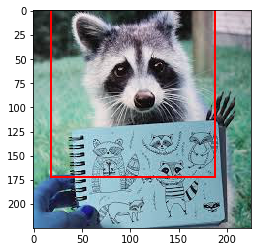

In [73]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [109]:
os.chdir('/content/drive/My Drive/Colab Notebooks/R9/')
os.listdir()

['R9_Delhi_Internal_Lab_Questions.ipynb',
 'daily-minimum-temperatures-in-me.csv',
 'train_labels.csv',
 'images_racoon.rar',
 'images']

### Load your data file

In [110]:
temperature_df = pd.read_csv('daily-minimum-temperatures-in-me.csv', index_col="Date")
temperature_df.sort_index(inplace=True)
temperature_df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Plot data

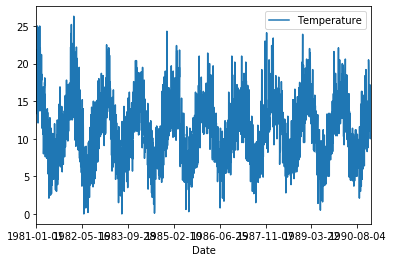

In [111]:
temperature_df.plot()

#### Descibe your dataframe

In [112]:
temperature_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


#### Check for null values

In [113]:
#Check for null values
temperature_df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values

In [0]:
# No null values

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9aac718be0>]],
      dtype=object)

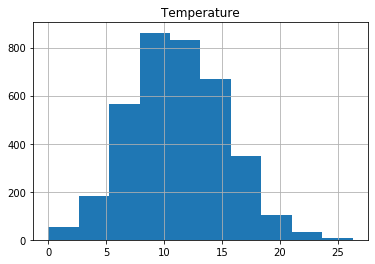

In [115]:
temperature_df.hist()

#### Check the maximum and minimum values

In [116]:
#Check Data Range
print('Min', np.min(temperature_df))
print('Max', np.max(temperature_df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(temperature_df)

#### Check the maximum and minimum values of scaled data

In [118]:
#Check Data Range
print('Min', np.min(scaled), '\nMax', np.max(scaled))

Min 0.0 
Max 1.0


#### Look into some of the scaled values

In [119]:
scaled[:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

### Split data into Training and Testing

In [0]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

In [0]:
#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [122]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [128]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("Shape of X_train:", X_train.shape, "\nShape of X_test:", X_test.shape)

Shape of X_train: (2554, 1, 1) 
Shape of X_test: (1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [129]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Summarize your model

In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [131]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2554 samples, validate on 1094 samples
Epoch 1/20
2554/2554 [==============================] - 1s 352us/sample - loss: 0.0992 - val_loss: 0.0313
Epoch 2/20
2554/2554 [==============================] - 0s 107us/sample - loss: 0.0168 - val_loss: 0.0133
Epoch 3/20
2554/2554 [==============================] - 0s 102us/sample - loss: 0.0140 - val_loss: 0.0124
Epoch 4/20
2554/2554 [==============================] - 0s 104us/sample - loss: 0.0132 - val_loss: 0.0119
Epoch 5/20
2554/2554 [==============================] - 0s 104us/sample - loss: 0.0125 - val_loss: 0.0111
Epoch 6/20
2554/2554 [==============================] - 0s 103us/sample - loss: 0.0118 - val_loss: 0.0104
Epoch 7/20
2554/2554 [==============================] - 0s 105us/sample - loss: 0.0113 - val_loss: 0.0098
Epoch 8/20
2554/2554 [==============================] - 0s 100us/sample - loss: 0.0109 - val_loss: 0.0094
Epoch 9/20

## Make Predictions and Evaluate your model

In [0]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [151]:
# Loads the weights
loss_and_metrics = model.evaluate(X_train, y_train)
print(loss_and_metrics)

2554/2554 [==============================] - 0s 34us/sample - loss: 0.0101
0.010099874468069573


In [150]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)

1094/1094 [==============================] - 0s 39us/sample - loss: 0.0087
0.008651461803407104


## Plot the results

In [0]:
#Un-normalize the predited data
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [0]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

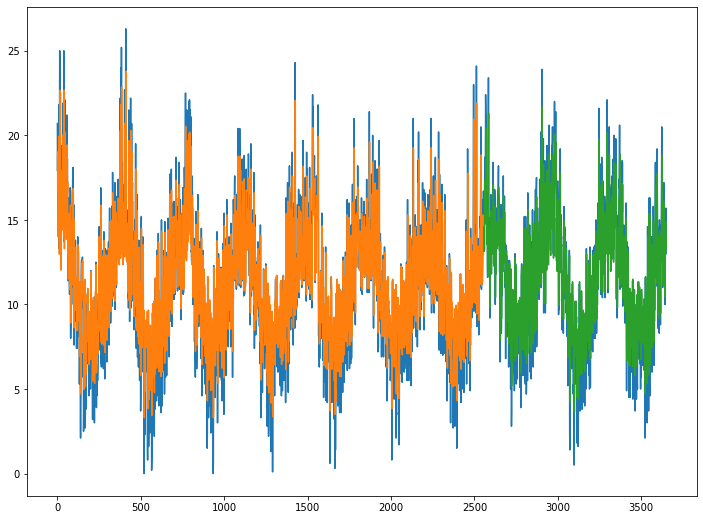

In [145]:
plt.figure(figsize=(12,9))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()